# Kr analysis (run 3614)

# Notebook configuration

In [7]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Na22/run3614.dst"

In [8]:
from __future__ import print_function, division

import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

Running on  Tue Apr 11 19:37:59 2017


#### General plotting options

In [9]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
XR1Opt  = "k"
XR2Opt  = "c"

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [10]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()

def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, save_plots, outputfolder)

### Input data

In [11]:
ifile = os.path.expandvars(inputfilename)
print("ifile:", ifile)

ifile: /Users/Gonzalo/github/NEXTdata/Na22/run3614.dst


# Read data

In [12]:
full = dstf.load_dst(ifile, "DST", "Events")
full.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105


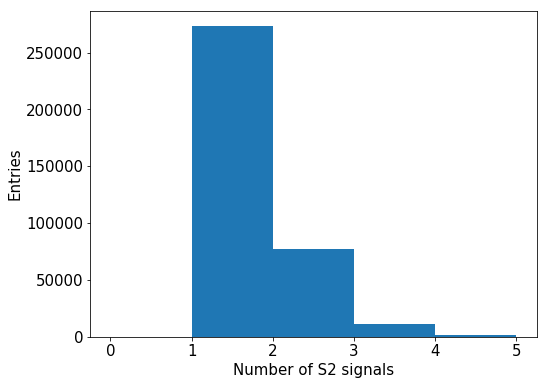

In [13]:
hist(full.nS2, 5, (0,5))
labels("Number of S2 signals", "Entries")

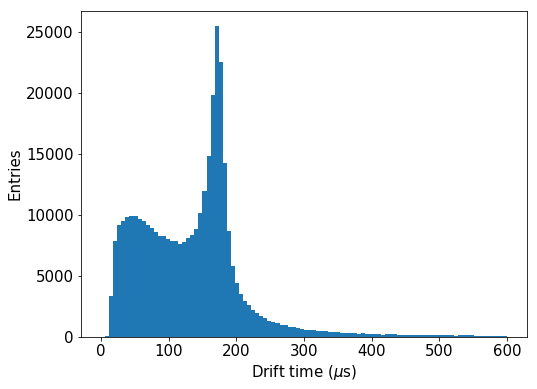

In [14]:
hist(full.Z, 100, (0,600))
labels("Drift time ($\mu$s)", "Entries")

In [15]:
XRrange = 2e3, 1e4
PPrange = 4e4, 1e5
7000/41.5*511

86192.77108433735

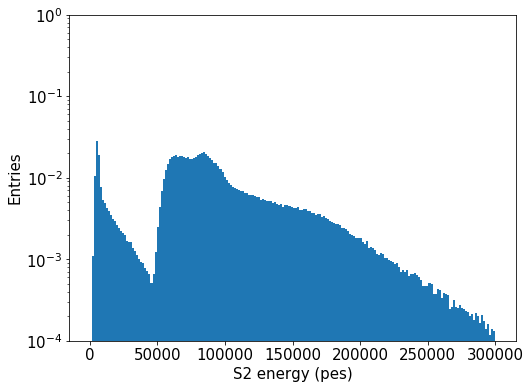

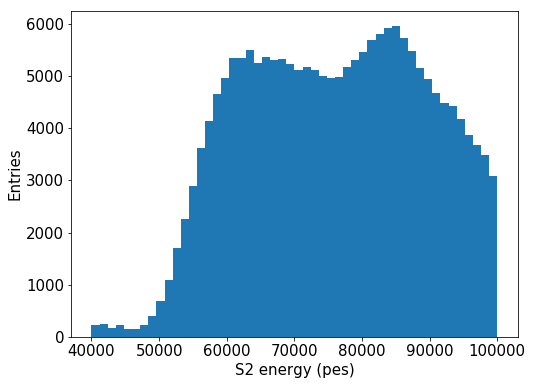

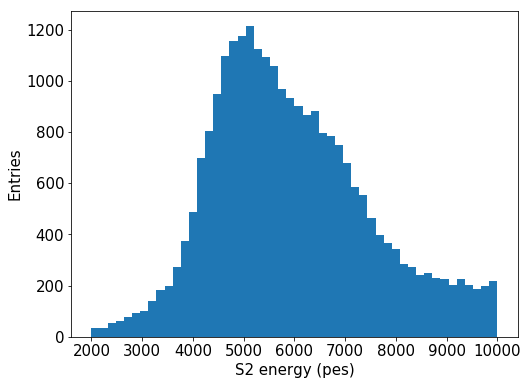

In [16]:
pdf(full.S2e, 200, (0,3e5))
labels("S2 energy (pes)", "Entries")

hist(full.S2e, 50, PPrange)
labels("S2 energy (pes)", "Entries")

hist(full.S2e, 50, XRrange)
labels("S2 energy (pes)", "Entries")

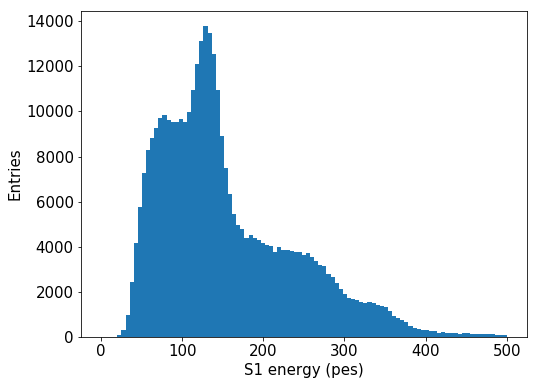

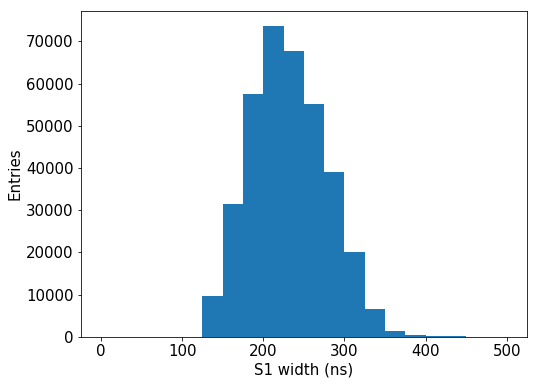

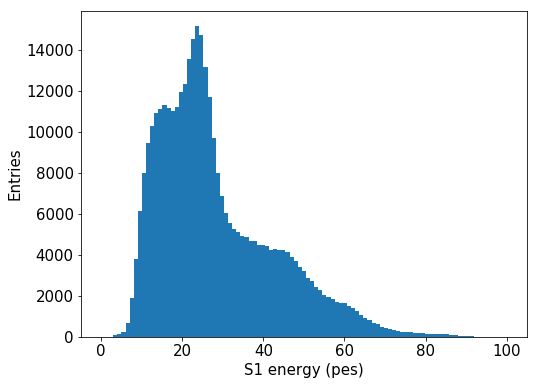

In [17]:
bins = np.linspace(0, 500, 100)
hist(full.S1e, bins)
labels("S1 energy (pes)", "Entries")

bins = np.linspace(0, 500, 21)
hist(full.S1w, bins)
labels("S1 width (ns)", "Entries")

bins = np.linspace(0, 100, 100)
hist(full.S1h, bins)
labels("S1 energy (pes)", "Entries")

# S2 energy vs Z

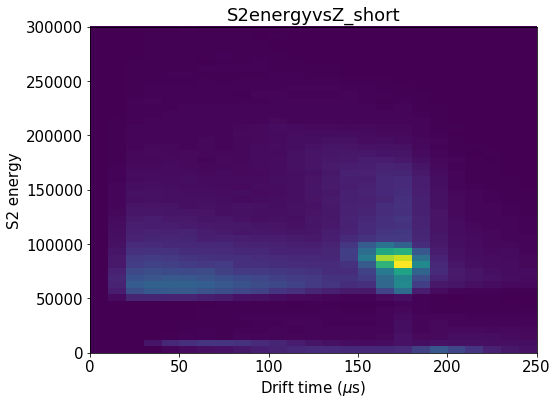

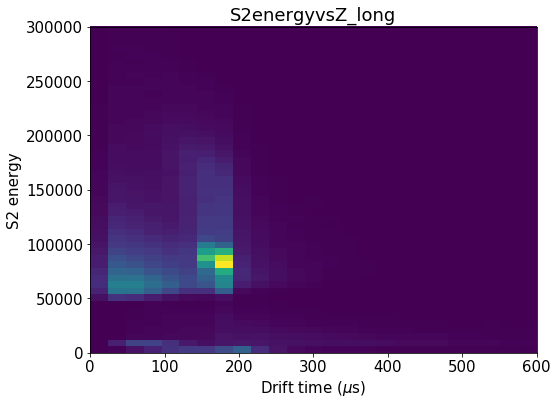

In [18]:
zrange = 0, 250
Erange = 0, 3e5
hist2d(full.Z, full.S2e, (25, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_short")

zrange = 0, 600
Erange = 0, 3e5
hist2d(full.Z, full.S2e, (25,  50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy")
save("S2energyvsZ_long")

# Short drift time: Z < 250 $\mu$s

In [19]:
zfid   = 0, 250
shortZ = full[coref.in_range(full.Z, *zfid)]
print("Ratio:", len(shortZ)/len(full))
shortZ.head()

Ratio: 0.9419419695112715


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
5,8,1.491674e+09,0,1,325.0,31.736614,165.305724,636875.0,31.787500,34261.953125,...,661412.5,47,24.5375,24.5375,-15.939325,-11.792324,19.827279,-2.504635,21.752563,23.834757


# S1 energy

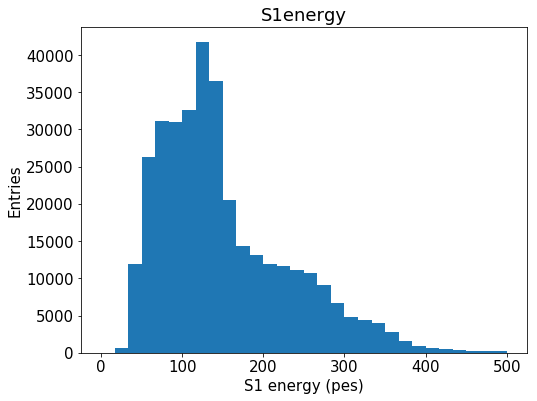

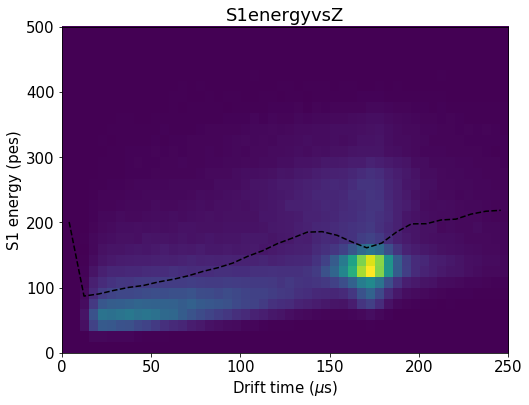

In [20]:
zrange = zfid
Srange = 0, 500

hist(shortZ.S1e, 30, range=Srange)
labels("S1 energy (pes)", "Entries")
save("S1energy")

hist2d(shortZ.Z, shortZ.S1e, (50, 30), range=(zrange, Srange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1e, 30, xrange=zrange, yrange=Srange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1energyvsZ")

# S1 width

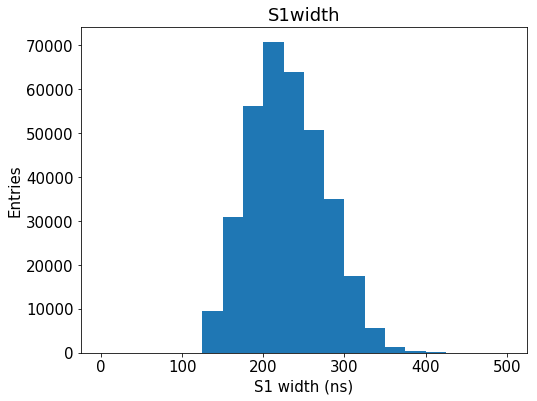

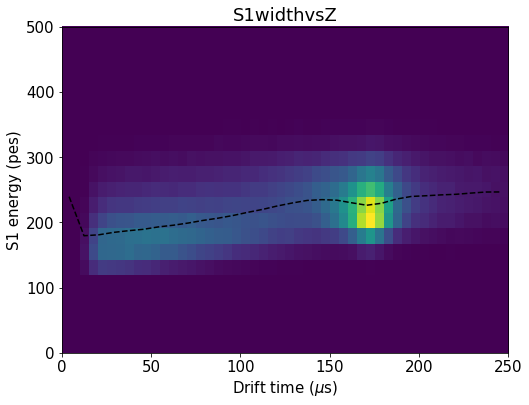

In [21]:
zrange = zfid
wrange = 0, 500

hist(shortZ.S1w, np.linspace(*wrange, 21))
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(shortZ.Z, shortZ.S1w, (50, 21), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

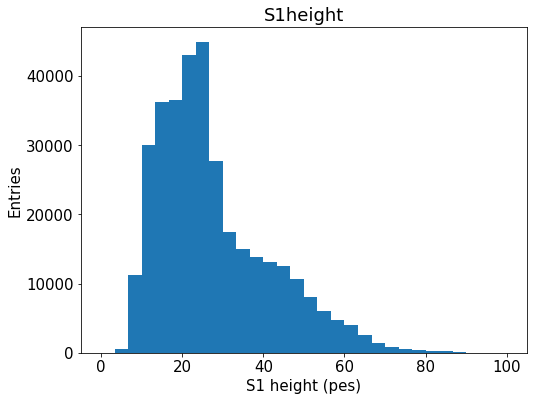

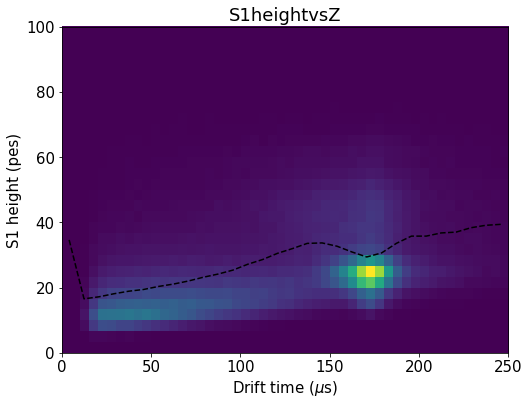

In [22]:
zrange = zfid
hrange = 0, 100

hist(shortZ.S1h, 30, range=hrange)
labels("S1 height (pes)", "Entries")
save("S1height")

hist2d(shortZ.Z, shortZ.S1h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S1h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)")
save("S1heightvsZ")

# S1 peak to area ratio

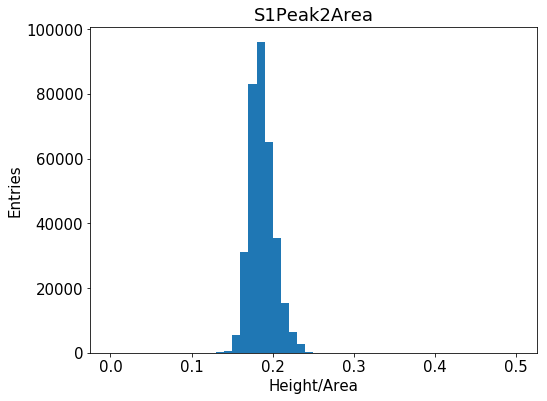

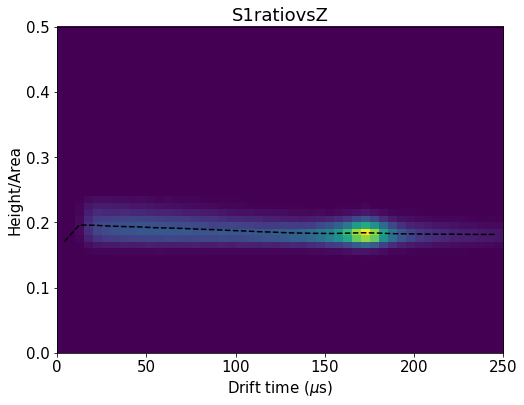

In [23]:
zrange = zfid
rrange = 0, 0.5

S1r = shortZ.S1h/shortZ.S1e
hist(S1r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S1Peak2Area")

hist2d(shortZ.Z, S1r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S1r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S1ratiovsZ")

# S2 energy

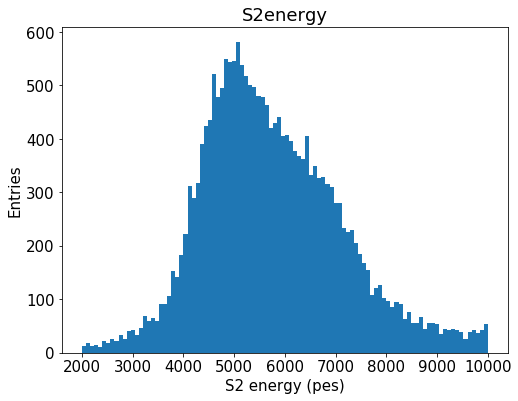

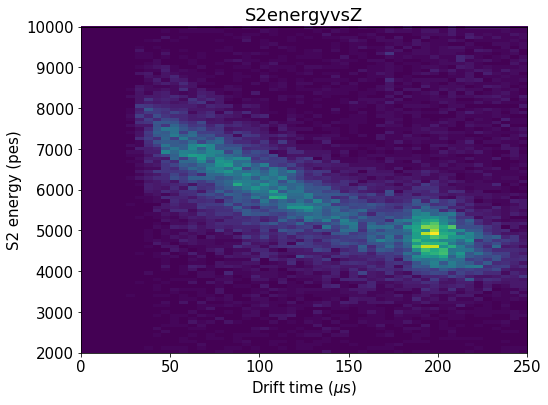

In [24]:
zrange = zfid
Erange = XRrange

hist(shortZ.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(shortZ.Z, shortZ.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z * 1e-3, shortZ.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

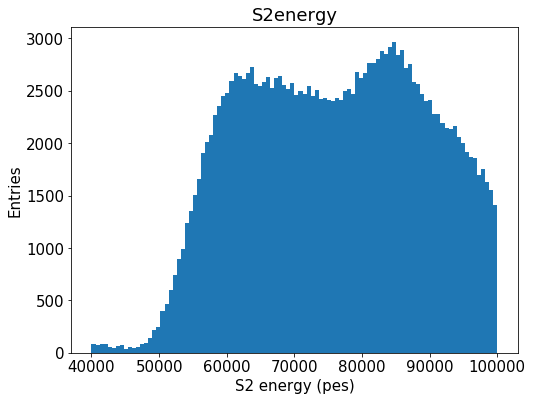

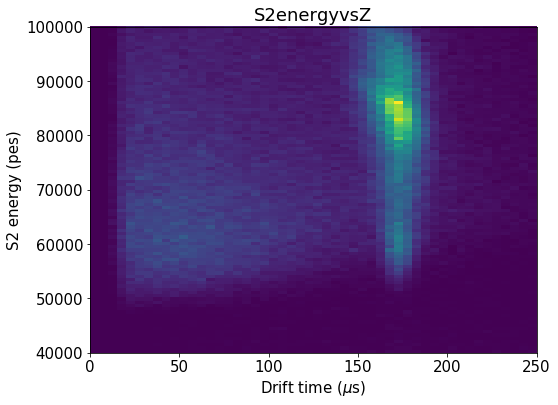

In [25]:
zrange = zfid
Erange = PPrange

hist(shortZ.S2e, 100, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy")

hist2d(shortZ.Z, shortZ.S2e, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(shortZ.Z * 1e-3, shortZ.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ")

# S2 width

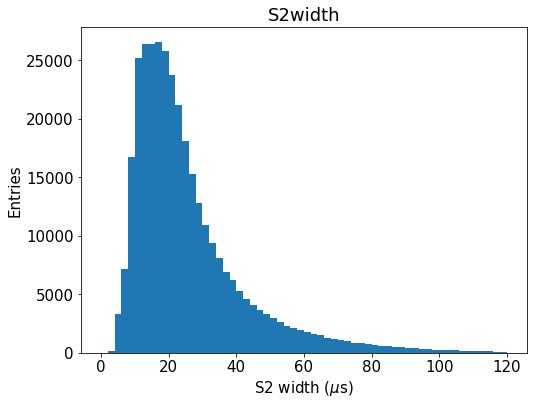

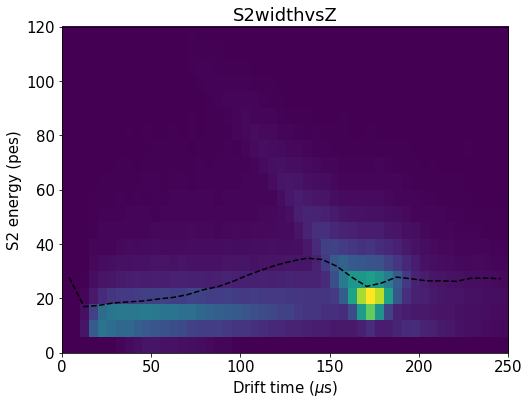

In [26]:
zrange = zfid
wrange = 0, 120

hist(shortZ.S2w, 60, range=wrange)
labels("S2 width ($\mu$s)", "Entries")
save("S2width")

hist2d(shortZ.Z, shortZ.S2w, (50, 20), range=(zrange, wrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2w, 30, xrange=zrange, yrange=wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2widthvsZ")

# S2 height

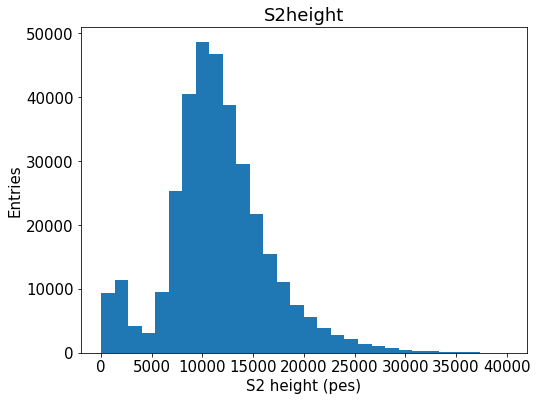

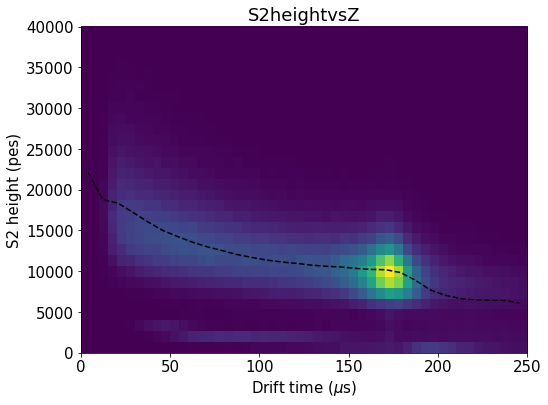

In [27]:
zrange = zfid
hrange = 0, 4e4

hist(shortZ.S2h, 30, range=hrange)
labels("S2 height (pes)", "Entries")
save("S2height")

hist2d(shortZ.Z, shortZ.S2h, (50, 30), range=(zrange, hrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.S2h, 30, xrange=zrange, yrange=hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

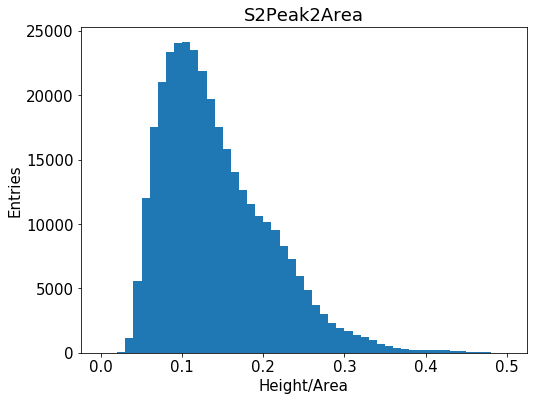

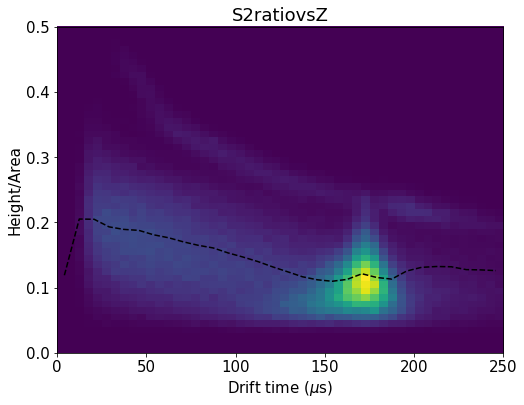

In [28]:
zrange = zfid
rrange = 0, 0.5

S2r = shortZ.S2h/shortZ.S2e

hist(S2r, 50, range=rrange)
labels("Height/Area", "Entries")
save("S2Peak2Area")

hist2d(shortZ.Z, S2r, (50, 50), range=(zrange, rrange))
x, y, _ = fitf.profileX(shortZ.Z, S2r, 30, xrange=zrange, yrange=rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area")
save("S2ratiovsZ")

# S2 vs S1

[  3.53074991e+03   2.60807808e+09] [[-0.99999948 -0.00101603]
 [ 0.00101603 -0.99999948]]


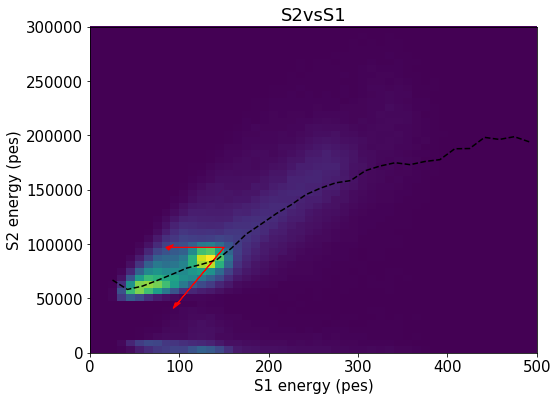

In [29]:
Srange = 0, 500
Erange = 0, 3e5

S = shortZ.S1e
E = shortZ.S2e

hist2d(S, E, (50, 50), range=(Srange, Erange))
x, y, _ = fitf.profileX(S, E, 30, xrange=Srange, yrange=Erange)
plt.plot(x, y, profOpt)

sel = fitf.in_range(S, *Srange) & coref.in_range(E, *Erange)
c = covariance(S[sel], E[sel])
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")

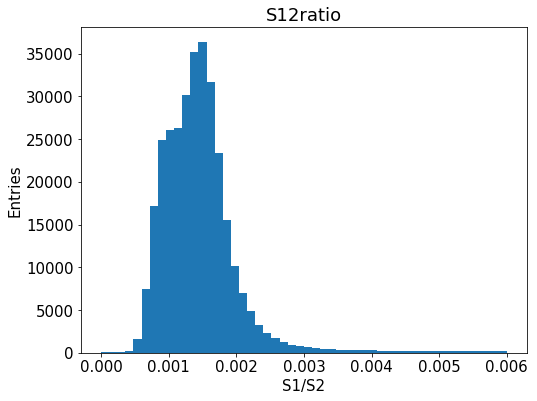

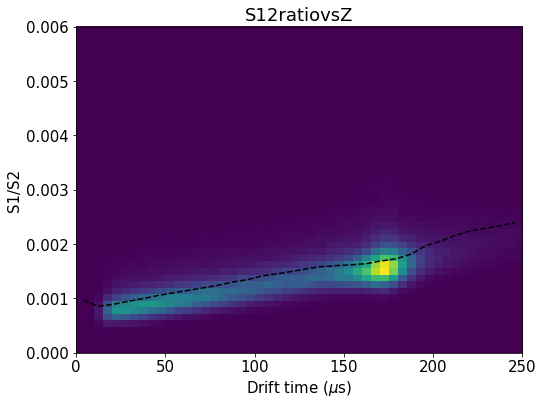

In [30]:
zrange = zfid
Rrange = 0, 0.006

S12r = shortZ.S1e/shortZ.S2e

hist(S12r, 50, range=Rrange)
labels("S1/S2", "Entries")
save("S12ratio")

hist2d(shortZ.Z, S12r, (50, 50), range=(zrange, Rrange))
x, y, _ = fitf.profileX(shortZ.Z, S12r, 30, xrange=zrange, yrange=Rrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2")
save("S12ratiovsZ")

# X-rays

In [31]:
XRrange = 2e3, 1e4
XR = shortZ[coref.in_range(shortZ.S2e, 2500, 8000)]
XR.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
33,38,1.491674e+09,1,2,150.0,14.287548,67.987579,606650.0,11.124375,547.778259,...,783687.5,1,177.0375,177.0375,-205.000000,-15.000000,205.548048,-3.068552,0.000000,0.000000
45,51,1.491674e+09,1,2,150.0,13.202993,63.658347,617375.0,5.129375,2506.131836,...,677912.5,4,60.5375,60.5375,-124.605900,-57.050477,137.045202,-2.712232,5.692910,4.045706
83,93,1.491674e+09,1,2,200.0,28.307272,147.862793,486400.0,9.578125,1025.614380,...,685712.5,3,199.3125,199.3125,58.267121,1.695648,58.291789,0.029093,4.714833,4.728493
88,97,1.491674e+09,1,2,225.0,20.952307,118.988705,630650.0,6.681750,1108.163086,...,779612.5,3,148.9625,148.9625,-162.021790,11.116134,162.402675,3.073091,4.592621,4.894740
97,105,1.491674e+09,1,2,250.0,14.728755,94.211445,589900.0,7.932688,1015.946838,...,751912.5,2,162.0125,162.0125,129.983840,45.000000,137.552894,0.333283,5.036084,0.000000


# Temporary fiducialization

In [32]:
XRfid = XR[XR.R < 100]
print("Ratio:", len(XRfid)/len(full))
print("Ratio:", len(XRfid)/len(XR))
XRfid.head()

Ratio: 0.019965021964553756
Ratio: 0.3758879958516982


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
83,93,1.491674e+09,1,2,200.0,28.307272,147.862793,486400.0,9.578125,1025.614380,...,685712.5,3,199.3125,199.3125,58.267121,1.695648,58.291789,0.029093,4.714833,4.728493
99,106,1.491674e+09,1,3,175.0,21.764864,106.785119,625325.0,7.712500,1168.938965,...,777112.5,2,151.7875,151.7875,-75.000000,29.147127,80.464620,2.770928,0.000000,4.960763
137,148,1.491674e+09,2,3,200.0,16.129667,84.943997,583250.0,8.891250,1110.295044,...,753387.5,1,170.1375,170.1375,-25.000000,-55.000000,60.415230,-1.997424,0.000000,0.000000
262,276,1.491674e+09,1,2,175.0,13.814150,71.631116,611000.0,8.166438,1436.626343,...,780062.5,3,169.0625,169.0625,51.138220,-78.012504,93.279517,-0.990555,4.887203,4.605428
347,365,1.491674e+09,1,2,175.0,25.634916,127.343555,506525.0,11.378750,1187.388916,...,687937.5,1,181.4125,181.4125,45.000000,25.000000,51.478151,0.507099,0.000000,0.000000


# S2 energy fiducialized

[ 8386.43318922  -372.82265281]


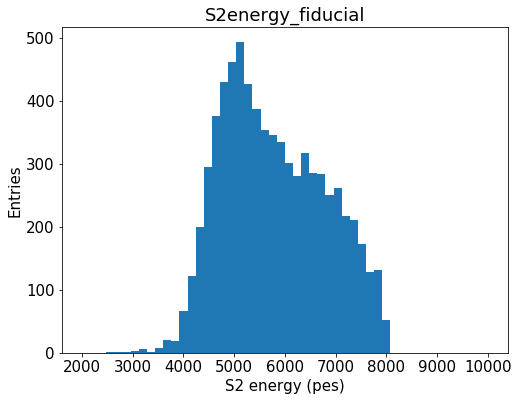

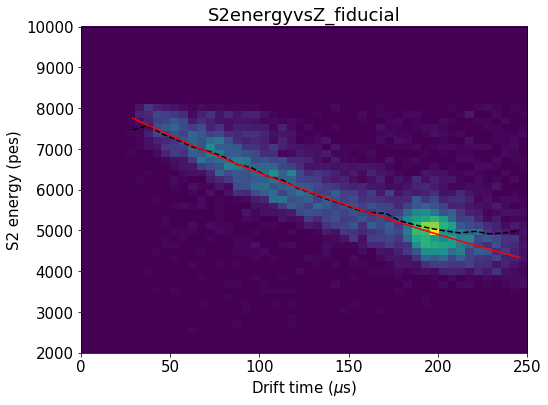

In [54]:
zrange = zfid
Erange = XRrange

hist(XRfid.S2e, 50, range=Erange)
labels("S2 energy (pes)", "Entries")
save("S2energy_fiducial")

hist2d(XRfid.Z, XRfid.S2e, (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(XRfid.Z, XRfid.S2e, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

f = fitf.fit(fitf.expo, x, y, (1e4, -200), fit_range=(50, 150))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyvsZ_fiducial")

zfun  = f.fn
zmin  = np.min(x)
zcorr = lambda z: zfun(zmin)/zfun(z)

# Correction by attachment

[  9.99999991e+05   7.62553034e+03   5.81587525e+02   5.00000000e+04
   8.59983365e+03   7.30091213e+02]
[  7.66376708e+03  -5.86151148e+10]


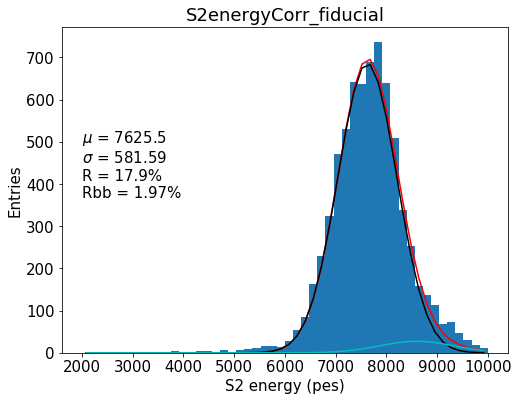

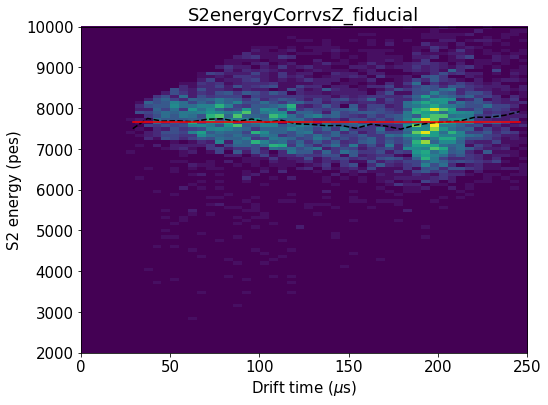

In [38]:
zrange = zfid
Erange = XRrange

E = XRfid.S2e * zcorr(XRfid.Z)

y, x, _ = hist(E, 50, range=Erange)

x    = x[:-1] + np.diff(x) * 0.5
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e3, 7500, 100, 1e3, 9000, 200
low  =  10, 7000,  50,  10, 8500, 100
upp  = 1e6, 8200, 800, 5e4, 9200, 800
f    = fitf.fit(fun, x, y, seed, fit_range=(6000, 10000), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))

labels("S2 energy (pes)", "Entries")
save("S2energyCorr_fiducial")

hist2d(XRfid.Z, E, (50, 100), range=(zrange, Erange))
x, y, _ = fitf.profileX(XRfid.Z, E, 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)

f = fitf.fit(fitf.expo, x, y, (1e4, -200))
plt.plot(x, f.fn(x), fitOpt)

print(f.values)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("S2energyCorrvsZ_fiducial")

# Tracking

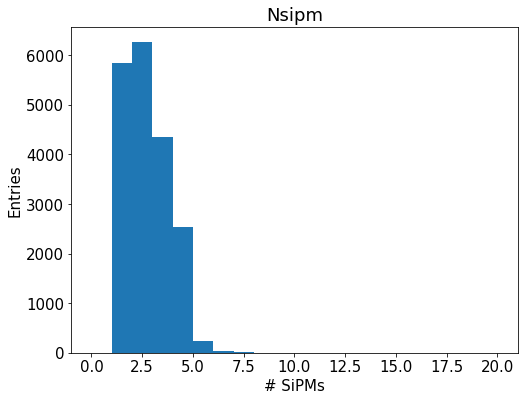

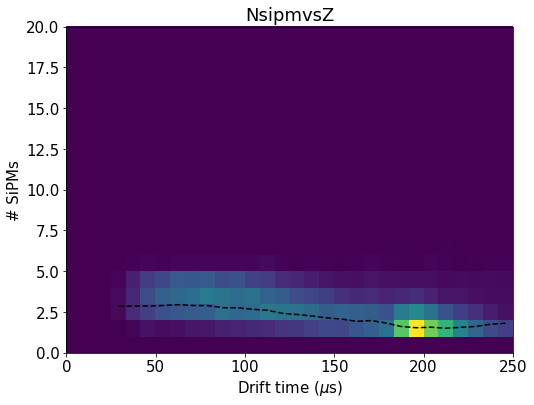

In [39]:
nrange = 0, 20
zrange = zfid

hist(XR.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(XR.Z, XR.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(XR.Z, XR.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
save("NsipmvsZ")


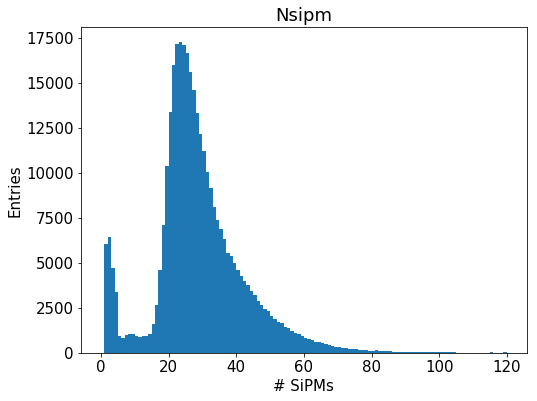

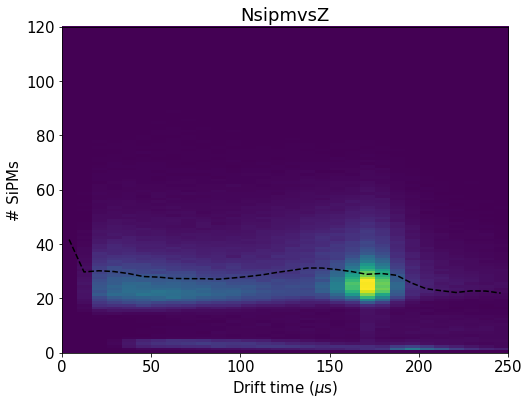

In [40]:
nrange = 0, 120
zrange = zfid

hist(shortZ.Nsipm, max(nrange), nrange)
labels("# SiPMs", "Entries")
save("Nsipm")

hist2d(shortZ.Z, shortZ.Nsipm, (30, max(nrange)), range=(zrange, nrange))
x, y, _ = fitf.profileX(shortZ.Z, shortZ.Nsipm, 30, xrange=zrange, yrange=nrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs")
save("NsipmvsZ")


# XR distribution

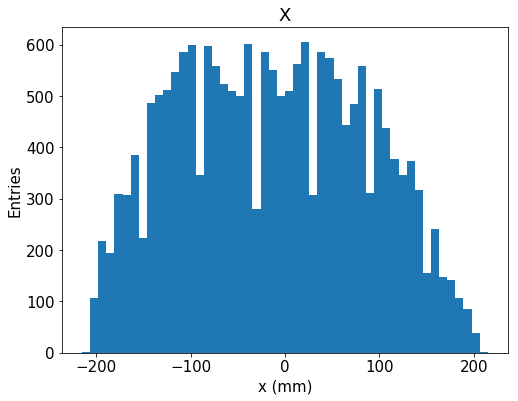

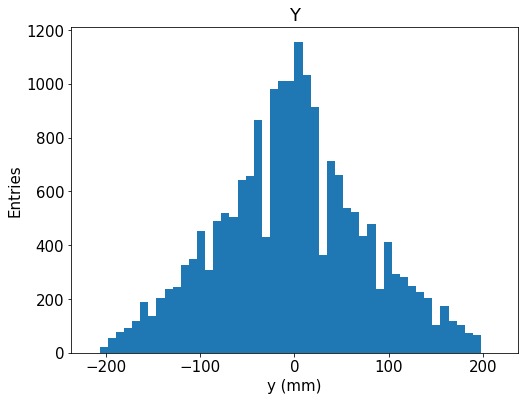

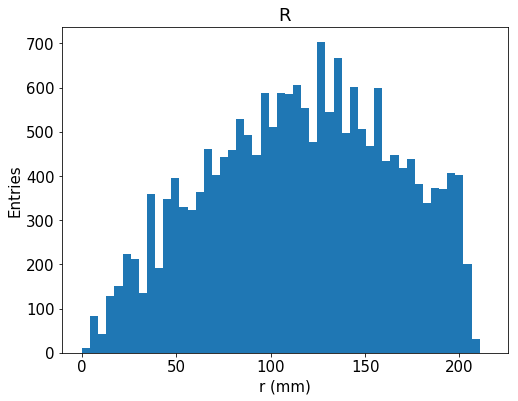

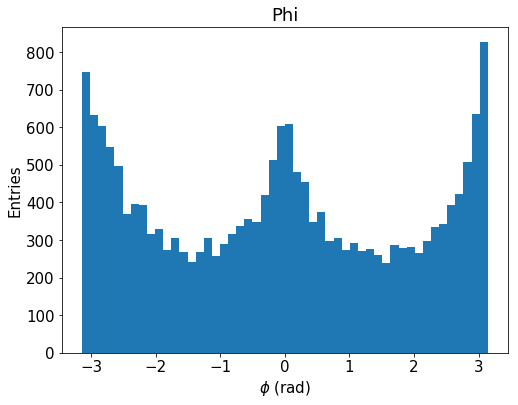

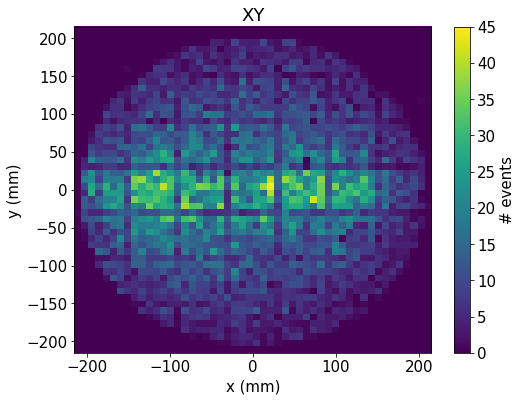

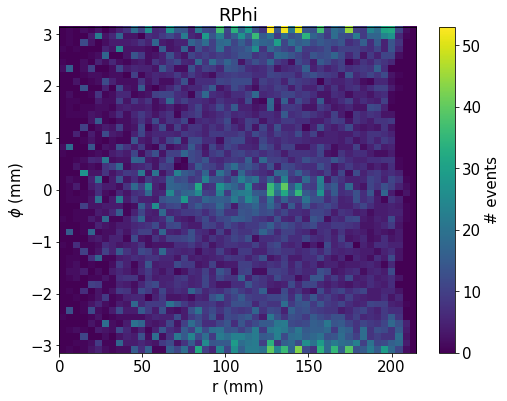

In [41]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi

hist(XR.X, 25, range=xrange)
labels("x (mm)", "Entries")
save("X")

hist(XR.Y, 25, range=yrange)
labels("y (mm)", "Entries")
save("Y")

hist(XR.R, 25, range=rrange)
labels("r (mm)", "Entries")
save("R")

hist(XR.Phi, 25, range=prange)
labels("$\phi$ (rad)", "Entries")
save("Phi")

nevts, xs, ys, _ = \
hist2d(XR.X, XR.Y, (50, 50), range=(xrange, yrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

hist2d(XR.R, XR.Phi, (50, 50), range=(rrange, prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")

# Tracking charge

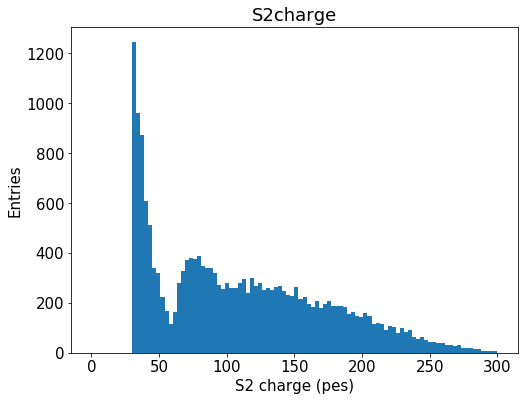

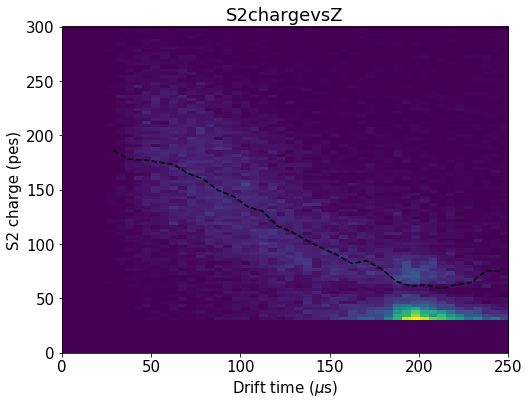

In [42]:
zrange = zfid
Qrange = 0, 300

hist(XR.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries")
save("S2charge")

hist2d(XR.Z, XR.S2q, (50, 100), range=(zrange, Qrange))
x, y, _ = fitf.profileX(XR.Z, XR.S2q, 30, xrange=zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)")
save("S2chargevsZ")

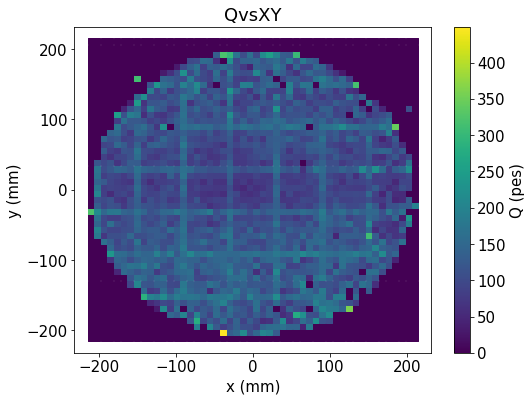

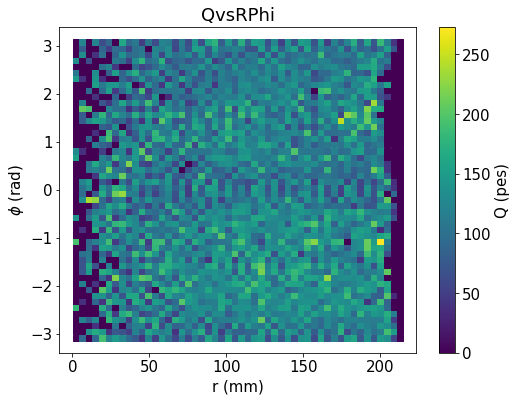

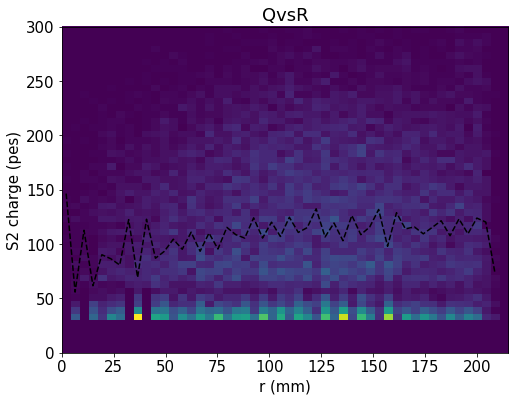

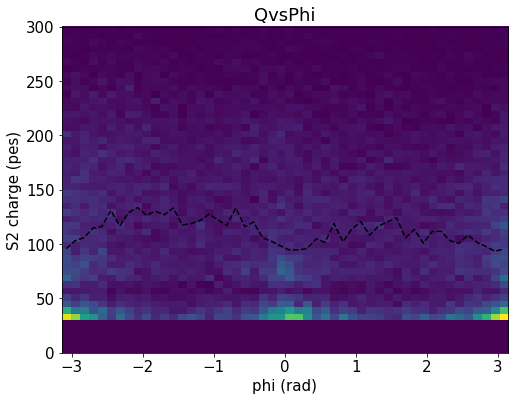

In [43]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Qrange =    0, 300

_, _, cb = profile_and_scatter(XR.X, XR.Y, XR.S2q, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, XR.S2q, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

hist2d(XR.R, XR.S2q, (50, 50), range=(rrange, Qrange))
x, y, _ = fitf.profileX(XR.R, XR.S2q, 50, xrange=rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

hist2d(XR.Phi, XR.S2q, (50, 50), range=(prange, Qrange))
x, y, _ = fitf.profileX(XR.Phi, XR.S2q, 50, xrange=prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)")
save("QvsPhi")


# Energy vs position

7731.42636958


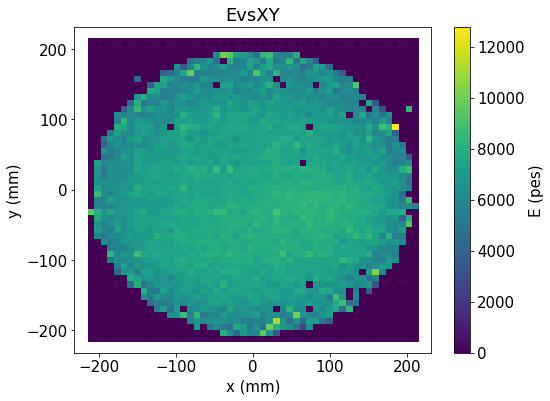

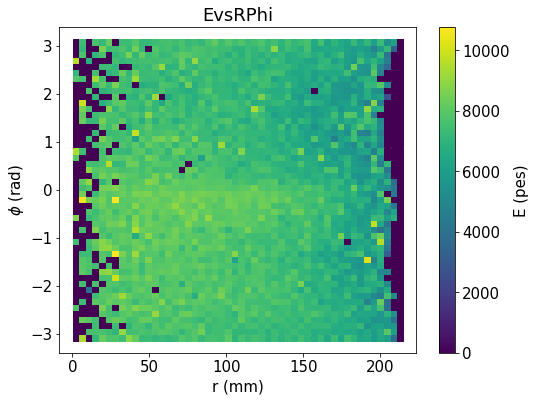

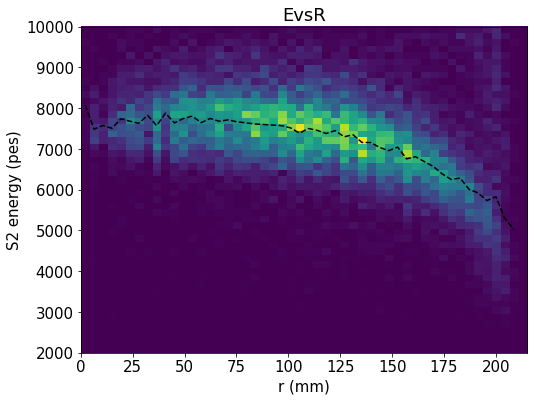

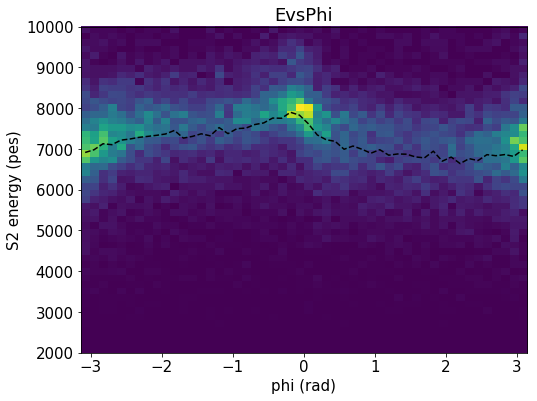

In [44]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  XRrange

E = XR.S2e * zcorr(XR.Z)

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])


# Correction by attachment and position

[  1.25038054e+06   7.55679461e+03   4.96083569e+02   1.50360842e+05
   8.68548609e+03   3.68991405e+02]


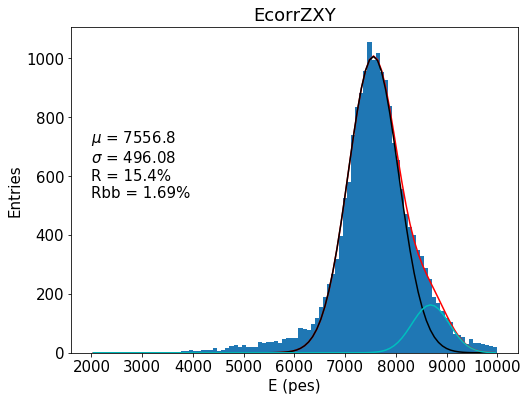

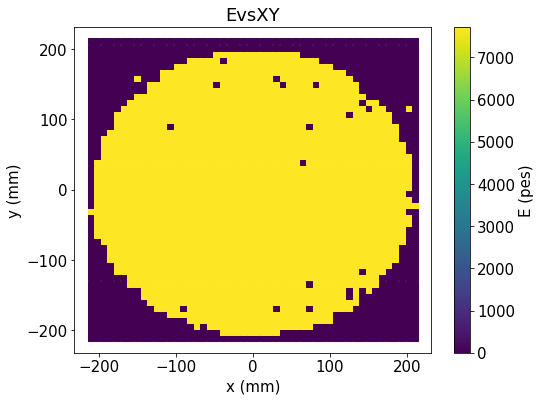

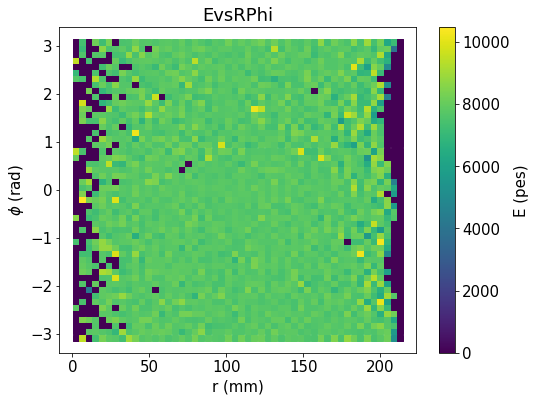

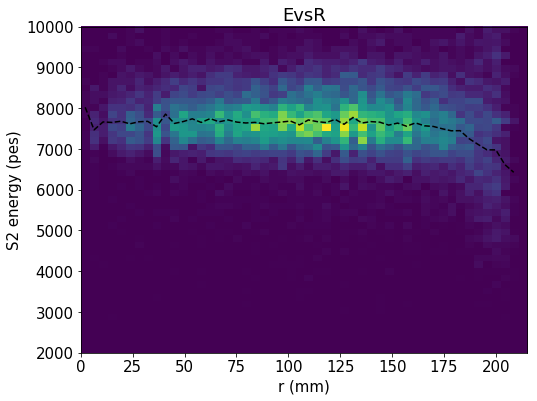

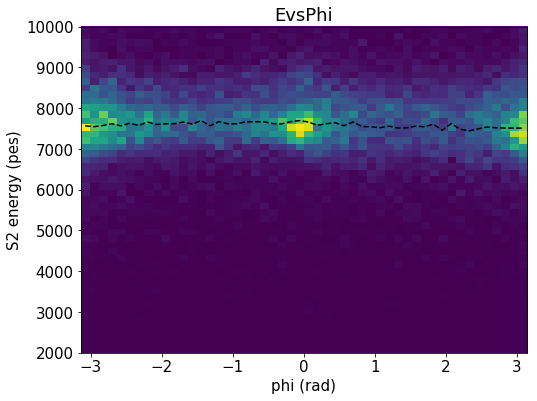

In [50]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 215
prange = - pi,  pi
Erange =  XRrange

E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)

y, x, _ = hist(E, 100, Erange)

x    = x[:-1] + np.diff(x) * 0.5
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e3, 7500, 100, 1e3, 9000, 200
low  =  10, 7000,  50,  10, 8000, 100
upp  = 5e6, 8200, 800, 5e5, 9200, 800
f    = fitf.fit(fun, x, y, seed, fit_range=(6000, 10000), bounds=(low, upp))
print(f.values)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))

labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange), weights=E)
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


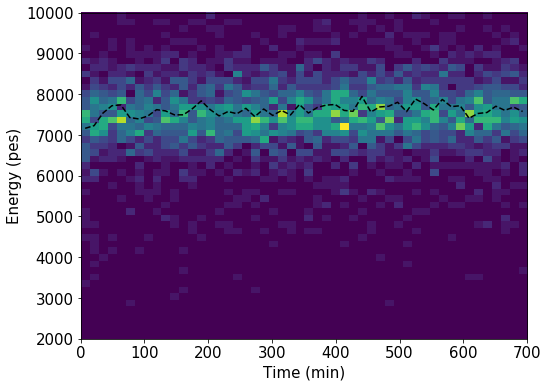

In [51]:
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)
T = (XR.time - np.min(XR.time))/60

Erange = XRrange
Trange = 0, 700

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

def get_timecorr(T, E):
    eref = np.max(E)
    def timecorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return timecorr
tcorr = get_timecorr(x, y)

[  2.53591243e+06   7.92468272e+03   5.35634110e+02   2.72563408e+05
   9.12715187e+03   3.83989818e+02]


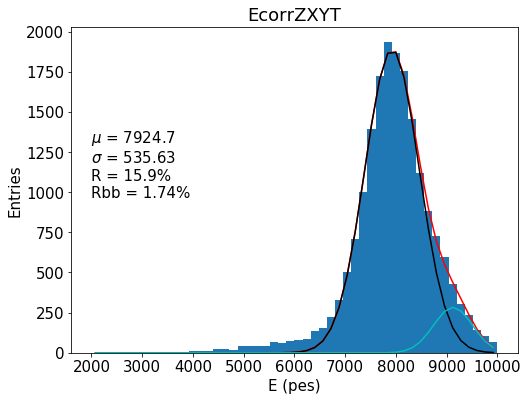

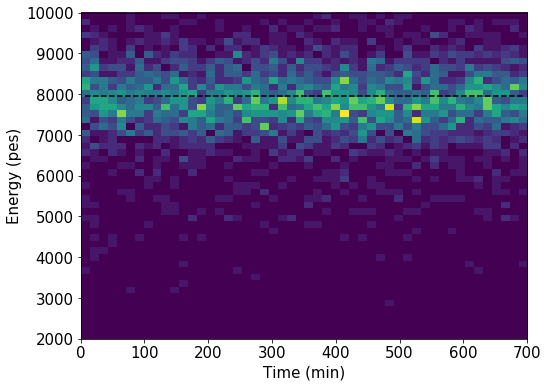

In [53]:
T = (XR.time - np.min(XR.time))/60
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values) * tcorr(T)

Trange = 0, 700
Erange = XRrange

y, x, _ = hist(E, 50, Erange)

x = x[:-1] + np.diff(x) * 0.5
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e3, 7500, 100, 1e3, 9000, 200
low  =  10, 7000,  50,  10, 8000, 100
upp  = 5e6, 8200, 800, 5e5, 9200, 800
f    = fitf.fit(fun, x, y, seed, fit_range=(6000, 10000), bounds=(low, upp))
print(f.values)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))

labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")
